# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

### <span style='color:#ff5f27'> 0.📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 12, 12, 19, 45, 35, 477742)

## <span style='color:#ff5f27'> 1.Download 

### <span style="color:#ff5f27;"> 1.1📡 Connect to Hopsworks Feature Store </span>

In [5]:
with open('../../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

#secrets = util.secrets_api(project.name)
secrets = hopsworks.get_secrets_api()

location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2024-12-12 20:27:52,007 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-12 20:27:52,074 INFO: Initializing external client
2024-12-12 20:27:52,076 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-12 20:27:53,884 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1150100


### <span style="color:#ff5f27;"> 1.2⚙️ Feature View Retrieval</span>


In [6]:
feature_view = fs.get_feature_view(
    name='air_quality_rolling_date_fv',
    version=1,
)


### <span style="color:#ff5f27;">1.3  Download the model from Model Registry</span>

In [8]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_rolling",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.596438E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">2. Inference: predict the future</span>



### <span style="color:#ff5f27;">2.0 Retrieve the weather predictions</span>

In [10]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-12-20 00:00:00+00:00,14.80,0.0,18.723459,271.101685,toscana
1,2024-12-16 00:00:00+00:00,11.55,0.0,0.804985,296.564972,toscana
2,2024-12-14 00:00:00+00:00,9.15,0.3,4.693825,184.398621,toscana
3,2024-12-13 00:00:00+00:00,7.40,0.0,6.849467,86.987282,toscana
4,2024-12-18 00:00:00+00:00,12.45,0.0,4.553679,288.435028,toscana
5,2024-12-17 00:00:00+00:00,12.50,0.0,10.239453,280.124603,toscana
6,2024-12-15 00:00:00+00:00,9.95,0.0,4.104631,74.744827,toscana
7,2024-12-21 00:00:00+00:00,12.30,0.0,5.588703,345.068542,toscana
8,2024-12-19 00:00:00+00:00,13.45,0.1,19.201874,239.589005,toscana


In [11]:
air_quality_roll_fg = fs.get_feature_group(
    name='air_quality_roll',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)


weather_df =weather_fg.read() 


air_quality_roll_df =air_quality_roll_fg.read() 
air_quality_roll_df = air_quality_roll_df.sort_values(by='date', ascending=False)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


In [12]:
weather_df = weather_df.sort_values(by='date', ascending=False)
weather_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2901,2024-12-21 00:00:00+00:00,12.300000,0.0,5.588703,345.068542,toscana
2893,2024-12-20 00:00:00+00:00,14.800000,0.0,18.723459,271.101685,toscana
2902,2024-12-19 00:00:00+00:00,13.450000,0.1,19.201874,239.589005,toscana
2897,2024-12-18 00:00:00+00:00,12.450000,0.0,4.553679,288.435028,toscana
2899,2024-12-17 00:00:00+00:00,12.500000,0.0,10.239453,280.124603,toscana
...,...,...,...,...,...,...
2037,2017-01-07 00:00:00+00:00,-1.458417,0.0,12.229406,89.674461,toscana
2333,2017-01-06 00:00:00+00:00,-0.410500,0.0,21.900904,30.942194,toscana
703,2017-01-05 00:00:00+00:00,3.768667,1.9,26.368616,20.398815,toscana
2531,2017-01-04 00:00:00+00:00,5.160333,0.4,9.585739,180.353638,toscana


In [13]:
air_quality_roll_df

,date,pm25,country,city,street,url,pm25_rolling
2764,2024-12-12 00:00:00+00:00,30.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,30.000000
2763,2024-11-25 00:00:00+00:00,50.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,40.000000
2762,2024-11-24 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,40.666667
2761,2024-11-23 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,44.666667
2760,2024-11-22 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,42.000000
...,...,...,...,...,...,...,...
1984,2017-01-07 00:00:00+00:00,55.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,81.000000
377,2017-01-06 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,57.666667
946,2017-01-05 00:00:00+00:00,50.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,49.000000
728,2017-01-04 00:00:00+00:00,82.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432,58.000000


In [14]:
# Ensure 'date' columns are in datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'])
air_quality_roll_df['date'] = pd.to_datetime(air_quality_roll_df['date'])

# Merge on 'city' and 'date'
merged_data = pd.merge(
    air_quality_roll_df[['city', 'date', 'pm25', 'pm25_rolling']],  # Select desired columns from air_quality_roll_df
    weather_df,  # Include all columns from weather_df
    on=['city', 'date'],  # Merge on both 'city' and 'date'
    how='inner'  # Use 'inner' to keep only matching rows
)

# Sort by 'date' in descending order
merged_data_past = merged_data.sort_values(by='date', ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
merged_data_past


,city,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,toscana,2024-12-12 00:00:00+00:00,30.0,30.000000,10.700000,0.0,9.449572,72.255241
1,toscana,2024-11-25 00:00:00+00:00,50.0,40.000000,9.385333,0.0,10.564941,126.447922
2,toscana,2024-11-24 00:00:00+00:00,42.0,40.666667,8.860332,0.0,12.410866,142.614624
3,toscana,2024-11-23 00:00:00+00:00,42.0,44.666667,5.524916,0.0,13.584932,149.311111
4,toscana,2024-11-22 00:00:00+00:00,42.0,42.000000,10.814499,3.1,33.586281,259.884705
...,...,...,...,...,...,...,...,...
2760,toscana,2017-01-07 00:00:00+00:00,55.0,81.000000,-1.458417,0.0,12.229406,89.674461
2761,toscana,2017-01-06 00:00:00+00:00,42.0,57.666667,-0.410500,0.0,21.900904,30.942194
2762,toscana,2017-01-05 00:00:00+00:00,50.0,49.000000,3.768667,1.9,26.368616,20.398815
2763,toscana,2017-01-04 00:00:00+00:00,82.0,58.000000,5.160333,0.4,9.585739,180.353638


In [15]:
batch_data['date'] = pd.to_datetime(batch_data['date'])
air_quality_roll_df['date'] = pd.to_datetime(air_quality_roll_df['date'])

# Merge on 'date' column
merged_data = pd.merge(
    batch_data,
    air_quality_roll_df[['date', 'pm25', 'pm25_rolling']],
    on='date',
    how='left'  # Use 'left' to keep all rows in batch_data
)

# Check the resulting DataFrame
merged_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,pm25_rolling
0,2024-12-20 00:00:00+00:00,14.80,0.0,18.723459,271.101685,toscana,NaN,NaN
1,2024-12-16 00:00:00+00:00,11.55,0.0,0.804985,296.564972,toscana,NaN,NaN
2,2024-12-14 00:00:00+00:00,9.15,0.3,4.693825,184.398621,toscana,NaN,NaN
3,2024-12-13 00:00:00+00:00,7.40,0.0,6.849467,86.987282,toscana,NaN,NaN
4,2024-12-18 00:00:00+00:00,12.45,0.0,4.553679,288.435028,toscana,NaN,NaN
5,2024-12-17 00:00:00+00:00,12.50,0.0,10.239453,280.124603,toscana,NaN,NaN
6,2024-12-15 00:00:00+00:00,9.95,0.0,4.104631,74.744827,toscana,NaN,NaN
7,2024-12-21 00:00:00+00:00,12.30,0.0,5.588703,345.068542,toscana,NaN,NaN
8,2024-12-19 00:00:00+00:00,13.45,0.1,19.201874,239.589005,toscana,NaN,NaN


In [16]:
last_three_past_data = merged_data_past.tail(3)
last_three_past_data


stacked_data = pd.concat([last_three_past_data, merged_data], ignore_index=True)
stacked_data

,city,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,toscana,2017-01-05 00:00:00+00:00,50.0,49.0,3.768667,1.9,26.368616,20.398815
1,toscana,2017-01-04 00:00:00+00:00,82.0,58.0,5.160333,0.4,9.585739,180.353638
2,toscana,2017-01-03 00:00:00+00:00,42.0,58.0,6.456165,21.0,23.784531,48.117687
3,toscana,2024-12-20 00:00:00+00:00,NaN,NaN,14.800000,0.0,18.723459,271.101685
4,toscana,2024-12-16 00:00:00+00:00,NaN,NaN,11.550000,0.0,0.804985,296.564972
5,toscana,2024-12-14 00:00:00+00:00,NaN,NaN,9.150000,0.3,4.693825,184.398621
6,toscana,2024-12-13 00:00:00+00:00,NaN,NaN,7.400000,0.0,6.849467,86.987282
7,toscana,2024-12-18 00:00:00+00:00,NaN,NaN,12.450000,0.0,4.553679,288.435028
8,toscana,2024-12-17 00:00:00+00:00,NaN,NaN,12.500000,0.0,10.239453,280.124603
9,toscana,2024-12-15 00:00:00+00:00,NaN,NaN,9.950000,0.0,4.104631,74.744827


### <span style="color:#ff5f27;">2.1 Making the predictions</span>

In [17]:
stacked_data.loc[3:, 'pm25_rolling'] = None
stacked_data

,city,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,toscana,2017-01-05 00:00:00+00:00,50.0,49.0,3.768667,1.9,26.368616,20.398815
1,toscana,2017-01-04 00:00:00+00:00,82.0,58.0,5.160333,0.4,9.585739,180.353638
2,toscana,2017-01-03 00:00:00+00:00,42.0,58.0,6.456165,21.0,23.784531,48.117687
3,toscana,2024-12-20 00:00:00+00:00,NaN,NaN,14.800000,0.0,18.723459,271.101685
4,toscana,2024-12-16 00:00:00+00:00,NaN,NaN,11.550000,0.0,0.804985,296.564972
5,toscana,2024-12-14 00:00:00+00:00,NaN,NaN,9.150000,0.3,4.693825,184.398621
6,toscana,2024-12-13 00:00:00+00:00,NaN,NaN,7.400000,0.0,6.849467,86.987282
7,toscana,2024-12-18 00:00:00+00:00,NaN,NaN,12.450000,0.0,4.553679,288.435028
8,toscana,2024-12-17 00:00:00+00:00,NaN,NaN,12.500000,0.0,10.239453,280.124603
9,toscana,2024-12-15 00:00:00+00:00,NaN,NaN,9.950000,0.0,4.104631,74.744827


In [18]:
# Step 1: Define features used for prediction
features = ['temperature_2m_mean', 'pm25_rolling', 'precipitation_sum', 
            'wind_speed_10m_max', 'wind_direction_10m_dominant']

# Step 2: Iterate through each row starting from the 3rd row (index 2)
for idx in range(2, len(stacked_data)):
    # For the first prediction (idx=2), use the last known rolling average
    if idx == 2:
        stacked_data.loc[idx, 'pm25_rolling'] = stacked_data.loc[1, 'pm25_rolling']
    
    # Prepare the row for prediction
    row_to_predict = stacked_data.iloc[idx]
    
    # Prepare input for the model
    X = row_to_predict[features].values.reshape(1, -1)
    
    # Predict pm25 for the current row
    predicted_pm25 = retrieved_xgboost_model.predict(X)[0]
    
    # Update the pm25 value for the current row
    stacked_data.loc[idx, 'pm25'] = predicted_pm25
    
    # Calculate rolling average for the next row
    if idx < len(stacked_data) - 1:  # If not the last row
        # Get the last 3 PM2.5 values (including the one we just predicted)
        last_three_pm25 = stacked_data['pm25'].iloc[max(0, idx-1):idx+1]
        # Calculate and set the rolling average for the next row
        stacked_data.loc[idx + 1, 'pm25_rolling'] = last_three_pm25.mean()

# Display the updated DataFrame
stacked_data.drop(['city'], axis=1, inplace=True)
stacked_data

,date,pm25,pm25_rolling,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-01-05 00:00:00+00:00,50.000000,49.000000,3.768667,1.9,26.368616,20.398815
1,2017-01-04 00:00:00+00:00,82.000000,58.000000,5.160333,0.4,9.585739,180.353638
2,2017-01-03 00:00:00+00:00,30.210155,58.000000,6.456165,21.0,23.784531,48.117687
3,2024-12-20 00:00:00+00:00,24.916719,56.105080,14.800000,0.0,18.723459,271.101685
4,2024-12-16 00:00:00+00:00,30.338079,27.563438,11.550000,0.0,0.804985,296.564972
5,2024-12-14 00:00:00+00:00,34.021538,27.627399,9.150000,0.3,4.693825,184.398621
6,2024-12-13 00:00:00+00:00,32.006992,32.179810,7.400000,0.0,6.849467,86.987282
7,2024-12-18 00:00:00+00:00,32.860168,33.014267,12.450000,0.0,4.553679,288.435028
8,2024-12-17 00:00:00+00:00,28.614834,32.433578,12.500000,0.0,10.239453,280.124603
9,2024-12-15 00:00:00+00:00,31.116014,30.737501,9.950000,0.0,4.104631,74.744827


### <span style="color:#ff5f27;">2.2 Saving the predictions (for monitoring) to a Feature Group</span>

In [19]:
batch_data = stacked_data.iloc[3:]
batch_data = batch_data[['date','temperature_2m_mean','wind_speed_10m_max','wind_direction_10m_dominant','pm25',]].rename(columns={'pm25': 'predicted_pm25'})
batch_data

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
3,2024-12-20 00:00:00+00:00,14.80,18.723459,271.101685,24.916719
4,2024-12-16 00:00:00+00:00,11.55,0.804985,296.564972,30.338079
5,2024-12-14 00:00:00+00:00,9.15,4.693825,184.398621,34.021538
6,2024-12-13 00:00:00+00:00,7.40,6.849467,86.987282,32.006992
7,2024-12-18 00:00:00+00:00,12.45,4.553679,288.435028,32.860168
8,2024-12-17 00:00:00+00:00,12.50,10.239453,280.124603,28.614834
9,2024-12-15 00:00:00+00:00,9.95,4.104631,74.744827,31.116014
10,2024-12-21 00:00:00+00:00,12.30,5.588703,345.068542,28.583700
11,2024-12-19 00:00:00+00:00,13.45,19.201874,239.589005,29.337965


In [20]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
6,2024-12-13 00:00:00+00:00,7.40,6.849467,86.987282,32.006992,pisa,toscana,italy,4
5,2024-12-14 00:00:00+00:00,9.15,4.693825,184.398621,34.021538,pisa,toscana,italy,3
9,2024-12-15 00:00:00+00:00,9.95,4.104631,74.744827,31.116014,pisa,toscana,italy,7
4,2024-12-16 00:00:00+00:00,11.55,0.804985,296.564972,30.338079,pisa,toscana,italy,2
8,2024-12-17 00:00:00+00:00,12.50,10.239453,280.124603,28.614834,pisa,toscana,italy,6
7,2024-12-18 00:00:00+00:00,12.45,4.553679,288.435028,32.860168,pisa,toscana,italy,5
11,2024-12-19 00:00:00+00:00,13.45,19.201874,239.589005,29.337965,pisa,toscana,italy,9
3,2024-12-20 00:00:00+00:00,14.80,18.723459,271.101685,24.916719,pisa,toscana,italy,1
10,2024-12-21 00:00:00+00:00,12.30,5.588703,345.068542,28.583700,pisa,toscana,italy,8


In [21]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 6 to 10
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   wind_speed_10m_max           9 non-null      float32                
 3   wind_direction_10m_dominant  9 non-null      float32                
 4   predicted_pm25               9 non-null      float32                
 5   street                       9 non-null      object                 
 6   city                         9 non-null      object                 
 7   country                      9 non-null      object                 
 8   days_before_forecast_day     9 non-null      int64                  
dtypes: datetime64[us, Etc/UTC](1), float32(4), int64(1), object(3)
memory usage: 576.0+ b

### <span style="color:#ff5f27;">2.3 Create Forecast graph</span>

2024-12-12 20:28:32,585 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



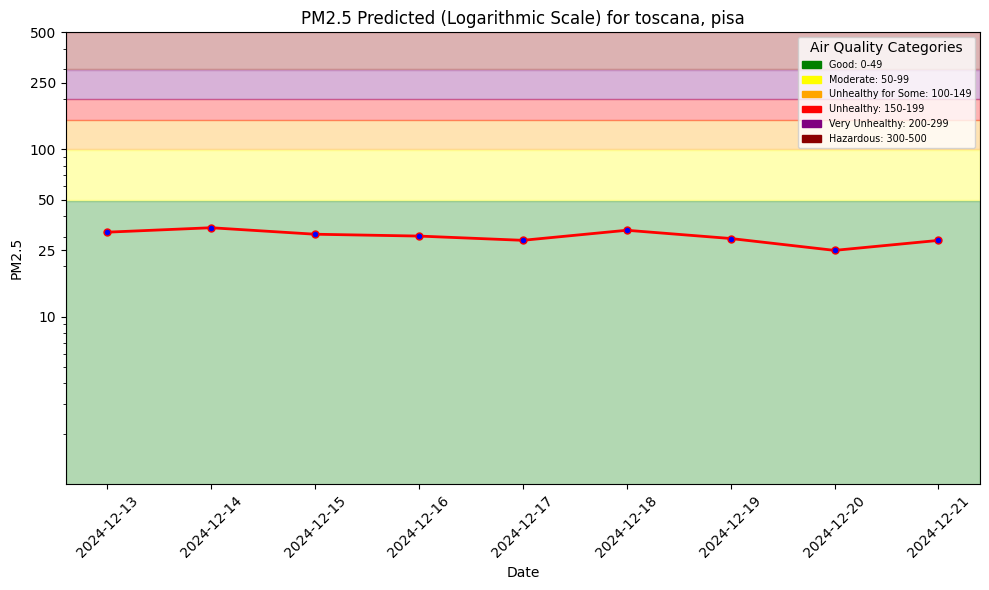

In [22]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast_rolling.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

### <span style="color:#ff5f27;">2.4 Create Forecast FeatureGroup</span>

We do this part because we want to retrieve afterwards what's our prediction was during the week.

In [23]:
monitor_rolling_fg = fs.get_or_create_feature_group(
    name='aq_predictions_rollings',
    description='Air Quality prediction monitoring Rolling',
    version=1,
    primary_key=['date', 'days_before_forecast_day'],  # Set the primary keys
    event_time="date"  # Set the event time column
)

In [24]:
monitor_rolling_fg.insert(batch_data, write_options={"wait_for_job": True})


Uploading Dataframe: 100.00% |█████████████████████████████████████████████████████████████████| Rows 9/9 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_rollings_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1150100/jobs/named/aq_predictions_rollings_1_offline_fg_materialization/executions
2024-12-12 20:28:56,369 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2024-12-12 20:29:18,796 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2024-12-12 20:29:21,979 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2024-12-12 20:32:47,432 INFO: Waiting for log aggregation to finish.
2024-12-12 20:33:19,502 INFO: Execution finished successfully.


(Job('aq_predictions_rollings_1_offline_fg_materialization', 'SPARK'), None)

In [25]:
df = monitor_rolling_fg.read()
df.drop(['country','street','city'], axis = 1, inplace= True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 


In [26]:
df

,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,days_before_forecast_day
0,2024-11-22 00:00:00+00:00,13.650000,18.514643,296.564972,22.414028,2
1,2024-11-24 00:00:00+00:00,15.550000,6.379216,196.389618,27.940733,4
2,2024-11-23 00:00:00+00:00,11.700000,2.036468,135.000107,34.780312,3
3,2024-11-26 00:00:00+00:00,18.250000,11.165805,200.772339,22.067041,6
4,2024-11-25 00:00:00+00:00,15.100000,1.835647,168.690109,27.819109,5
5,2024-11-27 00:00:00+00:00,16.850000,2.811690,309.805511,29.733114,7
6,2024-11-29 00:00:00+00:00,13.650000,1.297998,326.309906,28.924215,9
7,2024-11-21 00:00:00+00:00,13.050000,25.161400,236.082535,30.039627,1
8,2024-11-28 00:00:00+00:00,15.450000,1.938659,21.801476,35.506962,8
9,2024-11-30 00:00:00+00:00,9.350000,21.407139,47.726372,27.329676,9


In [27]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_rolling_fg.filter(monitor_rolling_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 


,date,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,13.050000,25.161400,236.082535,30.039627,pisa,toscana,italy,1
1,2024-11-22 00:00:00+00:00,12.600000,22.104116,307.056610,22.845650,pisa,toscana,italy,1
2,2024-11-23 00:00:00+00:00,12.150000,3.826853,228.814178,29.700590,pisa,toscana,italy,1
3,2024-11-24 00:00:00+00:00,12.950000,4.104631,37.875053,31.205992,pisa,toscana,italy,1
4,2024-11-25 00:00:00+00:00,14.950000,1.609969,63.435013,31.036562,pisa,toscana,italy,1
5,2024-11-26 00:00:00+00:00,18.049999,15.584300,186.632416,30.343115,pisa,toscana,italy,1


In [28]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df.tail()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,pm25,country,city,street,url
2760,2024-11-22 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2761,2024-11-23 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2762,2024-11-24 00:00:00+00:00,42.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2763,2024-11-25 00:00:00+00:00,50.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432
2764,2024-12-12 00:00:00+00:00,30.0,italy,toscana,pisa,https://api.waqi.info/feed/@9432


#### Merging the data

In [29]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-21 00:00:00+00:00,30.039627,38.0
1,2024-11-22 00:00:00+00:00,22.845650,42.0
2,2024-11-23 00:00:00+00:00,29.700590,42.0
3,2024-11-24 00:00:00+00:00,31.205992,42.0
4,2024-11-25 00:00:00+00:00,31.036562,50.0


In [30]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
#    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
#hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

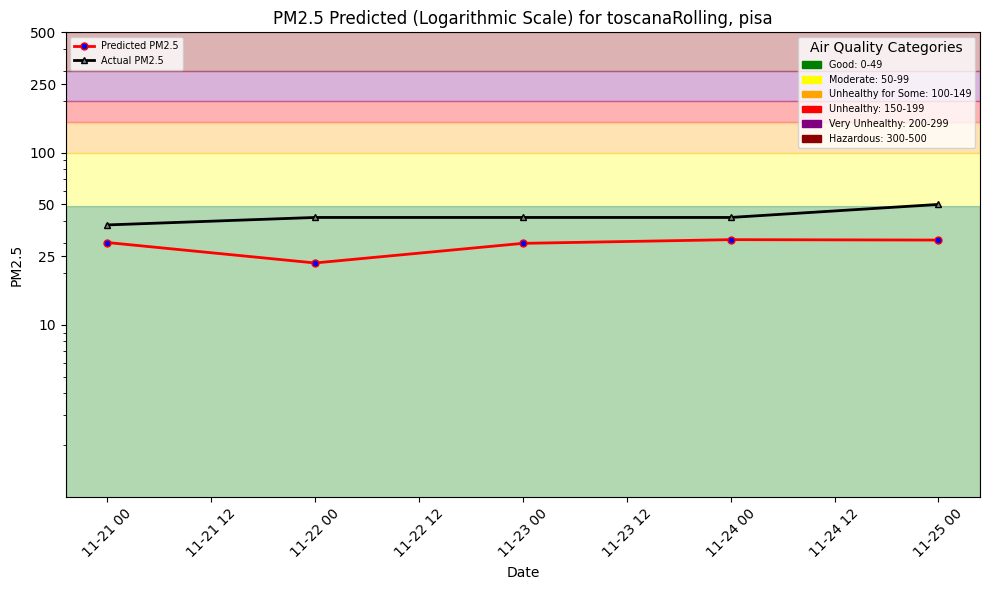

In [31]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day_rolling.png"
plt = util.plot_air_quality_forecast(city + "Rolling", street, hindcast_df, file_path, hindcast=True)
plt.show()

---